In [1]:
from collections import defaultdict
import copy
import json
import pickle

import gym
from gym_minigrid.minigrid import Grid
from gym_minigrid.wrappers import FullyObsWrapper, ReseedWrapper, RGBImgObsWrapper, RGBImgPartialObsWrapper
import matplotlib.pylab as plt
import networkx as nx
import numpy as np
from PIL import Image
import pytorch_ssim
from scipy.special import softmax
import seaborn as sns
import sklearn
from skimage.transform import resize, rescale, downscale_local_mean
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import vizdoom as vzd
import vizdoomgym


from rlpyt.models.dqn.dsr.idf_model import IDFModel
from rlpyt.envs.gym import make as gym_make
from rlpyt.utils.seed import set_seed
from gym_minigrid.envs.multiroom import MultiRoomEnv

### VizDoom Testing

In [ ]:
# Create DoomGame instance. It will run the game and communicate with you.
game = vzd.DoomGame()

# Now it's time for configuration!
# load_config could be used to load configuration instead of doing it here with code.
# If load_config is used in-code configuration will also work - most recent changes will add to previous ones.
# game.load_config("../../scenarios/basic.cfg")

# Sets path to additional resources wad file which is basically your scenario wad.
# If not specified default maps will be used and it's pretty much useless... unless you want to play good old Doom.
game.set_doom_scenario_path("/home/choang/research/vizdoomgym/vizdoomgym/envs/scenarios/my_way_home.wad")

# Sets map to start (scenario .wad files can contain many maps).
game.set_doom_map("map01")

# Sets resolution. Default is 320X240
game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)

# Sets the screen buffer format. Not used here but now you can change it. Default is CRCGCB.
game.set_screen_format(vzd.ScreenFormat.RGB24)

# Enables depth buffer.
game.set_depth_buffer_enabled(True)

# Enables labeling of in game objects labeling.
game.set_labels_buffer_enabled(True)

# Enables buffer with top down map of the current episode/level.
game.set_automap_buffer_enabled(True)
game.set_automap_mode(vzd.AutomapMode.OBJECTS)
game.set_automap_rotate(False)

# Sets other rendering options (all of these options except crosshair are enabled (set to True) by default)
game.set_render_hud(False)
game.set_render_minimal_hud(False)  # If hud is enabled
game.set_render_crosshair(False)
game.set_render_weapon(True)
game.set_render_decals(False)  # Bullet holes and blood on the walls
game.set_render_particles(False)
game.set_render_effects_sprites(False)  # Smoke and blood
game.set_render_messages(False)  # In-game messages
game.set_render_corpses(False)
game.set_render_screen_flashes(True)  # Effect upon taking damage or picking up items

# Adds buttons that will be allowed.
game.add_available_button(vzd.Button.MOVE_LEFT)
game.add_available_button(vzd.Button.MOVE_RIGHT)
game.add_available_button(vzd.Button.ATTACK)

# Adds game variables that will be included in state.
game.clear_available_game_variables()
game.add_available_game_variable(vzd.GameVariable.POSITION_X)
game.add_available_game_variable(vzd.GameVariable.POSITION_Y)
game.add_available_game_variable(vzd.GameVariable.POSITION_Z)

# Enables information about all objects present in the current episode/level.
game.set_objects_info_enabled(True)

# Enables information about all sectors (map layout).
game.set_sectors_info_enabled(True)

# Causes episodes to finish after 200 tics (actions)
game.set_episode_timeout(200)

# Makes episodes start after 10 tics (~after raising the weapon)
game.set_episode_start_time(10)

# Makes the window appear (turned on by default)
game.set_window_visible(True)

# Turns on the sound. (turned off by default)
game.set_sound_enabled(True)

# Sets the livin reward (for each move) to -1
game.set_living_reward(-1)

# Sets ViZDoom mode (PLAYER, ASYNC_PLAYER, SPECTATOR, ASYNC_SPECTATOR, PLAYER mode is default)
game.set_mode(vzd.Mode.PLAYER)

# Enables engine output to console.
#game.set_console_enabled(True)
# Initialize the game. Further configuration won't take any effect from now on.
game.init()


In [ ]:
game.new_episode()
state = game.get_state()

In [ ]:
state.game_variables

In [ ]:
plt.imshow(state.screen_buffer)

In [ ]:
plt.imshow(state.automap_buffer)

In [ ]:
print("State #" + str(state.number))
print("Player position: x:", state.game_variables[0], ", y:", state.game_variables[1], ", z:", state.game_variables[2])
print("Objects:")

# Print information about objects present in the episode.
for o in state.objects:
    print("Object id:", o.id, "object name:", o.name)
    print("Object position: x:", o.position_x, ", y:", o.position_y, ", z:", o.position_z)

    # Other available fields:
    #print("Object rotation angle", o.angle, "pitch:", o.pitch, "roll:", o.roll)
    #print("Object velocity x:", o.velocity_x, "y:", o.velocity_y, "z:", o.velocity_z)

    # Plot object on map
    if o.name == "DoomPlayer":
        plt.plot(o.position_x, o.position_y, color='green', marker='o')
    else:
        plt.plot(o.position_x, o.position_y, color='red', marker='o')

print("=====================")

print("Sectors:")

# Print information about sectors.
for s in state.sectors:
    print("Sector floor height:", s.floor_height, ", ceiling height:", s.ceiling_height)
    print("Sector lines:", [(l.x1, l.y1, l.x2, l.y2, l.is_blocking) for l in s.lines])

    # Plot sector on map
    for l in s.lines:
        if l.is_blocking:
            plt.plot([l.x1, l.x2], [l.y1, l.y2], color='black', linewidth=2)

# Show map
plt.show()

In [ ]:
env = gym.make('VizdoomMyWayHome-v0', labels=True, position=True)

# use like a normal Gym environment
state = env.reset()
state, reward, done, info = env.step(env.action_space.sample())


In [ ]:
state

### Python Testing

In [ ]:
class A:
    def __init__(self):
        self.item1 = 'A'

class B:
    def __init__(self):
        self.item2 = 'B'

In [ ]:
class C(A, B):
    def __init__(self):
        self.item = None
        A.__init__(self)
        B.__init__(self)
    
    def print_item(self):
        print(self.item1, self.item2)

In [ ]:
test = C()

In [ ]:
test.print_item()

### Numpy Testing

In [ ]:
A = np.array([5, 10])
B = np.array([5, 20])

In [ ]:
A / ( A + B)

In [ ]:
print(test)

In [ ]:
p = np.random.rand(10)
print(p)
test = np.random.rand(10)
A = np.random.randint(0, 10, 10)
B = np.random.randint(-20, -10, 10)

In [ ]:
np.where(test < p, A, B)

In [ ]:
test = np.concatenate([np.arange(0, 5), np.arange(19992, 20000)])
test

In [ ]:
test = np.array([0, 0, 0, 1, 0, 0, 1, 0, 0])
A = np.array([101, 102, 103, 104, 0, 1, 2, 3, 4, 5])
A[np.nonzero(test)[0]]

In [ ]:
np.maximum([1, 2, 3], [4, 1, 2])

In [ ]:
softmax(-1 * np.array([60.123, 60.001, 180.123]))

In [ ]:
test = np.random.random((5, 5))

In [ ]:
non_edges = test < 0.5
non_edges

In [ ]:
np.logical_not(non_edges)

In [ ]:
for index, i in np.ndenumerate(test):
    print(index, i)

In [ ]:
test = np.array([[0, 0], [0, 0]])
test.shape

In [ ]:
test = np.append(test, np.zeros((2, 1)), axis=1)
test.shape

In [ ]:
test = np.append(test, np.zeros((1, 3)), axis=0)
test.shape

In [ ]:
test[2, :] = 1
test[:, 2] = 1

In [ ]:
np.clip(test, 1, None)

In [ ]:
x = np.array([5, 6, 7, 9])

In [ ]:
m = softmax(-1 * x)
m

In [ ]:
np.random.choice(x, p=m)

### NetworkX Testing

In [ ]:
G = nx.Graph()
nx.add_path(G, [0, 1, 2])
nx.add_path(G, [0, 10, 2])

In [ ]:
list(nx.all_shortest_paths(G, source=0, target=2))

### Environment Testing

In [6]:
with open('../experiments/configs/test.json') as f:
    config = json.load(f)

mode = config['mode']
minigrid_config = config['env']
minigrid_config['seed'] = 0
minigrid_config['size'] = [25, 25]
minigrid_config['partial'] = False
minigrid_config['num_rooms'] = 4
minigrid_config['use_doors'] = True
# minigrid_config['tile_size'] = 8
env_id=None
set_seed(config['seed'])

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

using seed 333


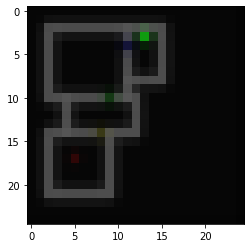

In [7]:
plt.imshow(env.reset())

In [8]:
env.agent_pos

array([ 5, 17])

In [9]:
env.goal_pos

array([13,  3])

In [ ]:
test = np.arange(25).reshape(5, 5)
test

In [ ]:
test[np.array([0, 1, 3])[:, None], [0, 1, 3]]

In [ ]:
test = set()

In [ ]:
A = np.expand_dims(env.agent_pos, 0)

In [ ]:
B = np.append(B, A, 0)

In [ ]:
for t in map(tuple, B):
    print(t)

In [ ]:
B[[1, 2]]

In [ ]:
obs = env.reset()

In [ ]:
env.goal_pos

In [ ]:
plt.imshow(obs)

In [ ]:
env.agent_pos

In [ ]:
env.landmark_goal_pos

In [ ]:
test = np.zeros((25, 25)) - 1  

In [ ]:
for room in env.rooms:
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            test[(x, y)] += 1

    if room.exitDoorPos is not None:
        test[room.exitDoorPos] += 1

In [ ]:
landmarks = set()

In [ ]:
for room in env.rooms:
    x = room.top[0] + (room.size[0] - 1) // 2
    y = room.top[1] + (room.size[1] - 1) // 2
    test[(x, y)] += 5
    landmarks.add((x, y))
    
    if room.exitDoorPos is not None:
        landmarks.add(room.exitDoorPos)
        test[room.exitDoorPos] += 10

In [ ]:
plt.imshow(test.T)
plt.colorbar()

In [ ]:
len(landmarks)

In [ ]:
env.unwrapped.agent_pos = np.array([15, 18])
plt.imshow(env.get_current_state()[0])

In [ ]:
env.unwrapped.agent_pos = np.array([16, 19])

In [ ]:
o, r, d, info = env.step(2)

In [ ]:
plt.imshow(o)

In [ ]:
true_dist = env.get_true_distances()

In [ ]:
from rlpyt.agents.dqn.dsr.landmark_agent import get_true_pos

In [ ]:
obs = env.reset()
true_pos = get_true_pos(obs)
true_pos

In [ ]:
obs = env.step(3)[0]
next_pos = get_true_pos(obs)
next_pos

In [ ]:
plt.imshow(obs)

In [ ]:
obs = env.reset()
plt.imshow(obs)
steps = int(5e3)

In [ ]:
h, w = env.grid.height, env.grid.width
incorrect_states = []

num_states = 0
dist_matrix = np.zeros((h * w, h * w))
valid = set()

for room in env.rooms:
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            valid.add((x, y))
    
    if room.exitDoorPos is not None:
        valid.add(room.exitDoorPos)

In [ ]:
for pos in valid:
    x, y = pos
    
    true_pos = y * h + x
    
    for adjacent in [[x-1, y], [x, y-1], [x+1, y], [x, y+1]]:
        adj_x, adj_y = adjacent
        if (adj_x, adj_y) in valid:
            true_adj_pos = adj_y * h + adj_x
            dist_matrix[true_pos, true_adj_pos] = 1

In [ ]:
G = nx.from_numpy_array(dist_matrix)

In [ ]:
lengths = nx.shortest_path_length(G)

In [ ]:
true_dist = np.zeros((w, h, w, h)) - 1

In [ ]:
for source, targets in lengths:
    source_x, source_y = source % h, source // h
    for target, dist in targets.items():
        target_x, target_y = target % h, target // h
        true_dist[source_x, source_y, target_x, target_y] = dist

In [ ]:
true_dist[15, 19, 3, 11]

In [ ]:
for i in range(steps):
    _, _, d, _ = env.step(env.action_space.sample())
    if d:
        print('{} steps done!'.format(i))
        env.reset()

In [ ]:
plt.imshow(env.visited.T)
plt.colorbar()

### Visualize Subgoal Policy

In [ ]:
def visualize_subgoal_policy(run, itr, subgoal, q_mode=None):
    config_file = '../data/local/{}/params.json'.format(run)
    with open(config_file, 'r') as f:
        config = json.load(f)
    mode = config['mode']
    seed = config['seed']
    config['env']['oracle'] = False
    set_seed(seed)

    device = torch.device('cuda', index=0)

    ENV_ID = 'MiniGrid-FourRooms-v0'
    env = gym_make(id=ENV_ID, mode=mode, minigrid_config=config['env'])
    obs = env.reset()
#     plt.imshow(obs)
    
    dsr = torch.load('../data/local/{}/dsr_itr_{}.pt'.format(run, itr)).detach().cpu().numpy()
    action_dsr = dsr.mean(axis=2)  # normalize direction dimension
    normed_dsr = action_dsr / np.linalg.norm(action_dsr, ord=2, axis=3, keepdims=True)

    if q_mode == 'sf':
        subgoal_dsr = normed_dsr[subgoal].mean(axis=0)
        subgoal_dsr = subgoal_dsr / np.linalg.norm(subgoal_dsr, ord=2)
        q_values = np.dot(normed_dsr, subgoal_dsr)   
    elif q_mode == 'sf-look':
        avg_dsr = action_dsr.mean(axis=2)
        normed_avg_dsr = avg_dsr / np.linalg.norm(avg_dsr, ord=2, axis=2, keepdims=True)
        subgoal_dsr = normed_avg_dsr[subgoal]
        
        side_size = normed_avg_dsr.shape[0]
        q_values = np.zeros(tuple(action_dsr.shape[:3])) + np.nan
        
        for x in range(side_size):
            for y in range(side_size):
                if any(np.isnan(normed_avg_dsr[x, y])):
                    continue
                new_pos = [[x + 1, y], [x, y + 1], [x - 1, y], [x, y - 1]]
                for i, pos in enumerate(new_pos):
                    n_x, n_y = pos
                    if n_x < 0 or n_x >= side_size or n_y < 0 or n_y >= side_size:
                        q_values[x, y, i] = -2
                    elif any(np.isnan(normed_avg_dsr[n_x, n_y])):
                        q_values[x, y, i] = -2
                    else:
                        q_values[x, y, i] = np.dot(normed_avg_dsr[n_x, n_y], subgoal_dsr)

    else:
        params = torch.load('../data/local/{}/itr_{}.pkl'.format(run, itr), map_location=device)
        feature_model = IDFModel(env.observation_space.shape, env.action_space.n, **config['agent']['idf_model_kwargs'])
        feature_model.load_state_dict(params['agent_state_dict']['idf_model'])
        feature_model.to(device)

        env.unwrapped.agent_pos = np.array(subgoal)

        obs = env.get_current_state()[0]
        obs = torch.Tensor(obs).unsqueeze(0)
        features = feature_model(obs.to(device), mode='encode')
        features = features.squeeze().detach().cpu().numpy()
        normed_features = features / np.linalg.norm(features, ord=2)

        q_values = np.dot(normed_dsr, normed_features)
    
    figure = plt.figure(figsize=(10, 10))
    plt.imshow(q_values.max(axis=2).T)
    for x in range(q_values.shape[0]):
        plt.axvline(x + 0.5, color='k', linestyle=':')
        for y in range(q_values.shape[1]):
            plt.axhline(y + 0.5, color='k', linestyle=':')

            if (x, y) == subgoal:
                circle = plt.Circle((x, y), 0.2, color='r')
                plt.gca().add_artist(circle)

            if any(np.isnan(q_values[x, y])):
                continue

            action = q_values[x, y].argmax()
            dx = 0
            dy = 0
            if action == 0:
                dx = 0.35
            elif action == 1:
                dy = 0.35
            elif action == 2:
                dx = -0.35
            else:
                dy = -0.35

            plt.arrow(x - dx, y - dy, dx, dy, head_width=0.3, head_length=0.3, fc='k', ec='k')
    plt.colorbar()

In [ ]:
# Random agent
subgoal = (3, 10)
run = '20200506/multiroom/run_0'
itr = 200000
itr -= 1
visualize_subgoal_policy(run, itr, subgoal)
visualize_subgoal_policy(run, itr, subgoal, 'sf')
visualize_subgoal_policy(run, itr, subgoal, 'sf-look')

In [ ]:
# perfect landmarks
subgoal = (6, 6)
run = '20200512/multiroom/run_30'
itr = 200000
itr -= 1
# visualize_subgoal_policy(run, itr, subgoal)
visualize_subgoal_policy(run, itr, subgoal, 'sf')
# visualize_subgoal_policy(run, itr, subgoal, 'sf-look')

In [ ]:
# Online landmarks in training only
subgoal = (16, 19)
run = '20200512/multiroom/run_33'
itr = 150000
itr -= 1
# visualize_subgoal_policy(run, itr, subgoal)
visualize_subgoal_policy(run, itr, subgoal, 'sf')
# visualize_subgoal_policy(run, itr, subgoal, 'sf-look')

In [ ]:
# Estimated landmark graph
subgoal = (10, 14)
run = '20200515/multiroom/run_69'
itr = 200000
itr -= 1
# visualize_subgoal_policy(run, itr, subgoal)
visualize_subgoal_policy(run, itr, subgoal, 'sf')
# visualize_subgoal_policy(run, itr, subgoal, 'sf-look')

In [ ]:
run = '20200513/multiroom/run_41'
itr = 20000
itr -= 1

In [ ]:
with open('../data/local/{}/params.json'.format(run)) as f:
    config = json.load(f)

mode = config['mode']
minigrid_config = config['eval_env']
env_id=None
set_seed(config['seed'])

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

device = torch.device('cuda', 0)

In [ ]:
params = torch.load('../data/local/{}/itr_{}.pkl'.format(run, itr))

In [ ]:
del model
model = IDFModel(env.observation_space.shape, env.action_space.n, **config['agent']['idf_model_kwargs'])
model.load_state_dict(params['agent_state_dict']['idf_model'])
model.to(device)

In [ ]:
h, w = env.grid.height, env.grid.width
features = torch.zeros((h, w, 4, 64), dtype=torch.float)
features += np.nan

for pos in env.get_possible_pos():
    x, y = pos
    for direction in range(4):
        env.unwrapped.agent_pos = np.array([x, y])
        env.unwrapped.agent_dir = direction
        obs, _, _, _ = env.get_current_state()
        model_inputs = torch.Tensor(obs).unsqueeze(0).to(device)

        features[x, y, direction] = model(model_inputs, mode='encode')

In [ ]:
subgoal = (3, 5)

np_features = features.detach().numpy()
features_matrix = np_features.mean(axis=2)
features_matrix = features_matrix / np.linalg.norm(features_matrix, ord=2, axis=2, keepdims=True)

subgoal_features = features_matrix[subgoal]

side_size = features_matrix.shape[0]
heatmap = np.zeros((side_size, side_size))
for r in range(side_size):
    for c in range(side_size):
#         heatmap[r, c] = np.dot(features_matrix[r, c], subgoal_features)
        heatmap[r, c] = np.linalg.norm(features_matrix[r, c] - subgoal_features)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(heatmap.T)
circle = plt.Circle(subgoal, 0.2, color='r')
plt.gca().add_artist(circle)
plt.title('L2 distance between (x, y) and {} in feature space'.format(subgoal))
plt.colorbar()

In [ ]:
np_features = features.detach().numpy()
raw_features = np_features.mean(axis=2)
valid_features = raw_features.reshape(25 * 25, 64)
walls = np.isnan(valid_features).any(axis=1)
valid_features = valid_features[~walls]

In [ ]:
rooms = np.zeros((25, 25))
for i, room in enumerate(env.rooms, 1):
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            rooms[x, y] = i
rooms = rooms.reshape(25 * 25)[~walls]

In [ ]:
embeddings = TSNE(n_components=2).fit_transform(valid_features)

In [ ]:
figure = plt.figure(figsize=(10, 10))
tsne_data = embeddings[rooms == 0]
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], label='Doorway', marker='*')
for i in range(1, len(env.rooms) + 1):
    tsne_data = embeddings[rooms == i]
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], label='Room ' + str(i))
plt.legend()

### Successor Features Heatmap

In [ ]:
def generate_dsr_grid(sr_matrix, starting_pos=(1, 8)):
    starting_sr = sr_matrix[starting_pos]
    
    side_size = sr_matrix.shape[0]
    
    grid = np.zeros((side_size, side_size))
    for x in range(side_size):
        for y in range(side_size):
            grid[x, y] = np.linalg.norm(sr_matrix[x, y] - starting_sr, 2)
    return grid


def visualize_dsr(sr_source, starting_pos=(1, 8), direction=-1, action=-1, normalize=True):
    if isinstance(sr_source, str):
        if 'pt' in sr_source:
            sr = torch.load(sr_source)
            sr = sr.detach().numpy()
        else:
            sr = np.load(sr_source)
    else:
        sr = sr_source

    if direction == -1:
        sr_matrix = sr.mean(axis=2)
        
    else:
        sr_matrix = sr[:, :, direction]

    if action == -1:
        sr_matrix = sr_matrix.mean(axis=2)
    else:
        sr_matrix = sr_matrix[:, :, action]
    
    side_size = sr_matrix.shape[0]
    
    if normalize:
        sr_matrix = sr_matrix.reshape(side_size ** 2, -1)
        sr_matrix = (sr_matrix - np.nanmean(sr_matrix, axis=0)) / np.nanstd(sr_matrix, axis=0)
        sr_matrix = sr_matrix.reshape(side_size, side_size, -1)
#         sr_matrix = sr_matrix / np.linalg.norm(sr_matrix, axis=2).reshape(side_size, side_size, -1)
    grid = generate_dsr_grid(sr_matrix, starting_pos)
    return sr_matrix, grid


In [ ]:
subgoal = (14, 4)
dsr, dsr_heatmap = visualize_dsr('../experiments/successor-data/20200411-run0-100k.pt', subgoal, -1, -1, True)
figure = plt.figure(figsize=(10, 10))
plt.imshow(dsr_heatmap.T)
circle = plt.Circle(subgoal, 0.2, color='r')
plt.gca().add_artist(circle)
plt.colorbar()

### Subgoal Q-Values

In [ ]:
from sklearn_extra.cluster import KMedoids

In [ ]:
config_file = '../data/local/20200411/multiroom/run_0/params.json'
with open(config_file, 'r') as f:
    config = json.load(f)

In [ ]:
mode = config['mode']
seed = config['seed']
set_seed(seed)

device = torch.device('cuda', index=0)

In [ ]:
checkpoint = '../data/local/20200411/multiroom/run_0/itr_99999.pkl'

In [ ]:
params = torch.load(checkpoint, map_location=device)

In [ ]:
ENV_ID = 'MiniGrid-FourRooms-v0'
env = gym_make(id=ENV_ID, mode=mode, minigrid_config=config['env'])
obs = env.reset()

In [ ]:
feature_model = IDFModel(env.observation_space.shape, env.action_space.n, **config['agent']['idf_model_kwargs'])
feature_model.load_state_dict(params['agent_state_dict']['idf_model'])
feature_model.to(device)

In [ ]:
dsr = torch.load('../experiments/successor-data/20200411-run0-100k.pt').detach().numpy()
action_dsr = dsr.mean(axis=2)  # normalize direction dimension
normed_dsr = action_dsr / np.linalg.norm(action_dsr, ord=2, axis=3, keepdims=True)

### Find Landmarks

In [ ]:
state_dsr = action_dsr.mean(axis=2)

In [ ]:
raw_s_features = state_dsr.reshape(25 * 25, 64)

In [ ]:
walls = np.isnan(raw_s_features).any(axis=1)
s_features = raw_s_features[~walls]

In [ ]:
indices = np.array(list(itertools.product(range(25), range(25))))

In [ ]:
kmedoids = KMedoids(n_clusters=8, random_state=seed).fit(s_features)
landmarks = kmedoids.medoid_indices_
landmark_states = indices[~walls][landmarks]
landmark_states

In [ ]:
landmark_map = walls.astype(int).reshape(25, 25)
landmark_map[landmark_states[:, 0], landmark_states[:, 1]] = 2

In [ ]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(landmark_map.T)

### Subgoal Policy

In [ ]:
subgoal = (14, 4)
env.unwrapped.agent_pos = np.array(subgoal)

obs = env.get_current_state()[0]
obs = torch.Tensor(obs).unsqueeze(0)
features = feature_model(obs.to(device), mode='encode')
features = features.squeeze().detach().cpu().numpy()
normed_features = features / np.linalg.norm(features, ord=2)



q_values = np.dot(normed_dsr, normed_features)

In [ ]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(q_values.max(axis=2).T)
for x in range(q_values.shape[0]):
    plt.axvline(x + 0.5, color='k', linestyle=':')
    for y in range(q_values.shape[1]):
        plt.axhline(y + 0.5, color='k', linestyle=':')
        
        if (x, y) == subgoal:
            circle = plt.Circle((x, y), 0.2, color='r')
            plt.gca().add_artist(circle)
        else:
            if any(np.isnan(q_values[x, y])):
                continue

            action = q_values[x, y].argmax()
            dx = 0
            dy = 0
            if action == 0:
                dx = 0.35
            elif action == 1:
                dy = 0.35
            elif action == 2:
                dx = -0.35
            else:
                dy = -0.35

            plt.arrow(x - dx, y - dy, dx, dy, head_width=0.3, head_length=0.3, fc='k', ec='k')

            
plt.colorbar()

### T-SNE Plots

In [ ]:
import itertools
from sklearn.manifold import TSNE

In [ ]:
dsr = torch.load('../experiments/successor-data/20200411-run0-100k.pt').detach().numpy()

In [ ]:
raw_sf = dsr.mean(axis=(2, 3))

In [ ]:
s_features = raw_sf.reshape(25 * 25, 64)
walls = np.isnan(s_features).any(axis=1)
s_features = s_features[~walls]

In [ ]:
sf_embedded = TSNE(n_components=2).fit_transform(s_features)

In [ ]:
rooms = np.zeros((25, 25))

In [ ]:
for i, room in enumerate(env.rooms, 1):
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            rooms[x, y] = i

In [ ]:
rooms = rooms.reshape(25 * 25)[~walls]

In [ ]:
figure = plt.figure(figsize=(10, 10))
data = sf_embedded[rooms == 0]
plt.scatter(data[:, 0], data[:, 1], label='Doorway', marker='*')
for i in range(1, len(env.rooms) + 1):
    data = sf_embedded[rooms == i]
    plt.scatter(data[:, 0], data[:, 1], label='Room ' + str(i))
plt.legend()